In [1]:

import bluepyopt as bpop
import bluepyopt.ephys as ephys
import pickle
from sciunit.scores import ZScore
from sciunit import TestSuite
from sciunit.scores.collections import ScoreArray
import sciunit
import numpy as np
from neuronunit.optimisation.optimization_management import dtc_to_rheo, switch_logic,active_values
from neuronunit.tests.base import AMPL, DELAY, DURATION

import quantities as pq
PASSIVE_DURATION = 500.0*pq.ms
PASSIVE_DELAY = 200.0*pq.ms
import matplotlib.pyplot as plt
from bluepyopt.ephys.models import ReducedCellModel
import numpy
from neuronunit.optimisation.optimization_management import test_all_objective_test
from neuronunit.optimisation.optimization_management import check_binary_match, three_step_protocol,inject_and_plot_passive_model
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
from neuronunit.optimisation.data_transport_container import DataTC
dtc = DataTC()
'''
MODEL_PARAMS["IZHI"].pop('C',None)
MODEL_PARAMS["IZHI"].pop('k',None)
MODEL_PARAMS["IZHI"].pop('vt',None)
MODEL_PARAMS["IZHI"].pop('vr',None)
MODEL_PARAMS["IZHI"].pop('vPeak',None)
'''
import numpy as np

import copy 
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from collections import Iterable

from sciunit.scores import ZScore
tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests
nu_tests[0].score_type = ZScore

/home/user/anaconda3/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


# Create Two Random points in hypervolume.
Make sure points are sufficiently far apart
Instance two models with those parameters

In [2]:
model = "IZHI"

In [3]:
%%capture
dist = 0
while dist<28:
    nu_tests0, OM, target0 = test_all_objective_test(MODEL_PARAMS[model],
                                                   model_type=model,
                                                   protocol={'allen':False,'elephant':True})






    nu_tests1, OM, target1 = test_all_objective_test(MODEL_PARAMS[model]
                                                   ,model_type=model,
                                                   protocol={'allen':False,'elephant':True})

    target0.attrs.pop('dt',None)
    target0.attrs.pop('Iext',None)
    target1.attrs.pop('dt',None)
    target1.attrs.pop('Iext',None)

    a = np.array(list(target0.attrs.values()))
    b = np.array(list(target1.attrs.values()))
    dist = numpy.linalg.norm(a-b)
    print(a,b)
    #if type(dist) is type(Iterable):
    try:
        dist = dist[0]
    except:
        pass
    print(dist,'dist \n\n\n')

Build point cloud "constellations" these are two cell model populations focused on either one of each of the two random points.

In [4]:
%%capture
def random_p(backend,target):
    ranges = MODEL_PARAMS[backend]
    import numpy, time
    date_int = int(time.time())
    numpy.random.seed(date_int)

    random_param1 = {} # randomly sample a point in the viable parameter space.
    for k in ranges.keys():
        mean = target.attrs[k]
        var = np.var(ranges[k])
        std = np.sqrt(var)
        sample = numpy.random.normal(loc=mean, scale=std/10, size=1)[0]
        random_param1[k] = sample
    return random_param1
popa = []
popb = []
backend="IZHI"
for i in range(0,14):
    aa = random_p(backend,target0)
    dtc = DataTC(backend=backend)
    dtc.attrs = aa
    dtc.tests = nu_tests0
    dtc.self_evaluate()
    popa.append(dtc)
    
    
    bb = random_p(backend,target1)
    dtc = DataTC(backend=backend)
    dtc.attrs = bb
    dtc.tests = nu_tests0
    dtc.self_evaluate()
    popb.append(dtc)
    
all_neurons = popa 
all_neurons.extend(popb)



# optionally confirm things 
are as you would expect

In [5]:
target1.attrs;

In [6]:
mean_parametersb = {}
for k,v in dtc.attrs.items():
    mean_parametersb[k] = np.mean([n.attrs[k] for n in popb])
mean_parametersb;

In [7]:
target0.attrs;

In [8]:
mean_parametersa = {}

for k,v in dtc.attrs.items():
    mean_parametersa[k] = np.mean([n.attrs[k] for n in popa])
mean_parametersa;

In [9]:

mean_measurements = {}
mean_parameters = {}
containers = {}
for i,tt in enumerate(dtc.tests):
    containers[tt.name] = []
    for dtc_local in all_neurons:
        try:
            containers[tt.name].append(dtc_local.tests[i].prediction['value'])
        except:
            containers[tt.name].append(dtc_local.tests[i].prediction['mean'])
    mean_measurements[tt.name] = np.mean(containers[tt.name])
    
    
for k,v in dtc.attrs.items():
    mean_parameters[k] = np.mean([n.attrs[k] for n in all_neurons])
    
mean_parameters;


In [10]:
mean_measurements;

In [13]:
#mean_model = dtc
mean_model = DataTC(backend="IZHI")
#mean_model.attrs = mean_a_dict

mean_model.attrs = mean_parameters
mean_model.attrs.pop('dt',None)
mean_model.attrs.pop('Iext',None)
print(mean_model)
mean_model.tests = nu_tests0
mean_model.self_evaluate()
store_mean_model_tests = {}
for t in mean_model.tests:
    try:
        print(t.name,t.prediction['mean'])
        store_mean_model_tests[t.name] = t.prediction['mean']
    except:
        print(t.name,t.prediction['value'])
        store_mean_model_tests[t.name] = t.prediction['value']
store_mean_model_tests

{'C': 171.4878818444587, 'k': 0.8520177983124974, 'vr': -67.24061488543425, 'vt': -46.503777282213356, 'vPeak': 38.24511751897201, 'a': 0.025009760547478787, 'b': 12.347696607244009, 'c': -48.59290838621821, 'd': 109.26483504991157}
time taken on block 0.0022058486938476562 
RheobaseTest 186.328125 pA
TimeConstantTest 3.089603158287804 ms
RestingPotentialTest -67.24061488543425 mV
InputResistanceTest 33006489.333828878 kg*m**2/(s**3*A**2)
CapacitanceTest 9.360593085315561e-11 s**4*A**2/(kg*m**2)
InjectedCurrentAPWidthTest 0.00102 s
InjectedCurrentAPAmplitudeTest 60.28110299532033 mV
InjectedCurrentAPThresholdTest -22.035985476348323 mV


{'RheobaseTest': array(186.328125) * pA,
 'TimeConstantTest': array(3.08960316) * ms,
 'RestingPotentialTest': array(-67.24061489) * mV,
 'InputResistanceTest': array(33006489.33382888) * kg*m**2/(s**3*A**2),
 'CapacitanceTest': array(9.36059309e-11) * s**4*A**2/(kg*m**2),
 'InjectedCurrentAPWidthTest': array(0.00102) * s,
 'InjectedCurrentAPAmplitudeTest': array(60.281103) * mV,
 'InjectedCurrentAPThresholdTest': array(-22.03598548) * mV}

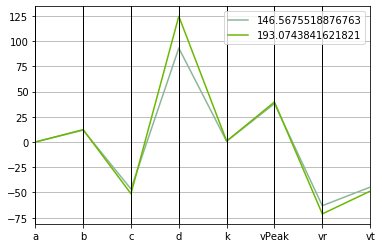

,C,a,b,c,d,k,vPeak,vr,vt
0,146.567552,0.024554,11.819188,-46.550456,93.116138,0.740259,38.084033,-63.118685,-44.71271
1,193.074384,0.025254,12.290177,-51.213888,124.708170,0.959548,39.725834,-71.241583,-48.68088


In [27]:
plt.figure()
import pandas as pd

df = pd.DataFrame([target0.attrs,target1.attrs])

import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

parallel_coordinates(df,list(df.columns)[0])
#plt.semilogy()
plt.show()
df

In [16]:

nu_tests1 = list(nu_tests1.values())
nu_tests0 = list(nu_tests0.values())

mean_o_dict={}
for o0,o1 in zip(nu_tests0,nu_tests1):
    mean_o_dict[o1.name] = np.mean([o0.observation['mean'],o1.observation['mean']])*o0.observation['mean'].units
mean_o_dict    
new_tests = copy.copy(nu_tests0)

for t0 in new_tests:
    t0.observation = {}
    t0.observation['mean'] = mean_o_dict[t0.name]

mean_a_dict={}
for k,v in target0.attrs.items():
    mean_a_dict[k] = np.mean([v,target1.attrs[k]])
mean_a_dict    


{'C': 169.8209680249292,
 'a': 0.024904238951988913,
 'b': 12.054682126320365,
 'c': -48.882171824924015,
 'd': 108.91215422514762,
 'k': 0.8499037024921562,
 'vPeak': 38.90493372207744,
 'vr': -67.1801340682682,
 'vt': -46.6967951869405}

In [17]:
mean_o_dict;

In [18]:
dtc = DataTC(backend="IZHI")
dtc.attrs = mean_a_dict
dtc.tests = new_tests
dtc.attrs
target0

In [19]:

m = dtc.dtc_to_model()

preds = OrderedDict()
for t in new_tests:
    try:
        preds[t.name] = t.generate_prediction(m)['mean']
    except:
        try:
            preds[t.name] = t.generate_prediction(m)['value']
        except:
            pass
preds;

In [28]:
'''
import numpy as np
import matplotlib.pyplot as plt


width = 0.35       
mean_o_dict = { k:mean_o_dict[k] for k in preds.keys() }
measure0 = list(mean_o_dict.values())
N = len(measure0)
ind = np.arange(N)    # the x locations for the groups

measure1 = list(preds.values())


plt.bar(ind,measure0, width)
#plt.bar(ind,measure1, width)
plt.semilogy()


plt.ylabel('Measurements')
plt.title('Measurements grouped by test')
plt.xticks(ind, (list(preds.keys())))
plt.xticks(rotation=90)
plt.show()
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n\nwidth = 0.35       \nmean_o_dict = { k:mean_o_dict[k] for k in preds.keys() }\nmeasure0 = list(mean_o_dict.values())\nN = len(measure0)\nind = np.arange(N)    # the x locations for the groups\n\nmeasure1 = list(preds.values())\n\n\nplt.bar(ind,measure0, width)\n#plt.bar(ind,measure1, width)\nplt.semilogy()\n\n\nplt.ylabel('Measurements')\nplt.title('Measurements grouped by test')\nplt.xticks(ind, (list(preds.keys())))\nplt.xticks(rotation=90)\nplt.show()\n"

In [20]:
new_tests;

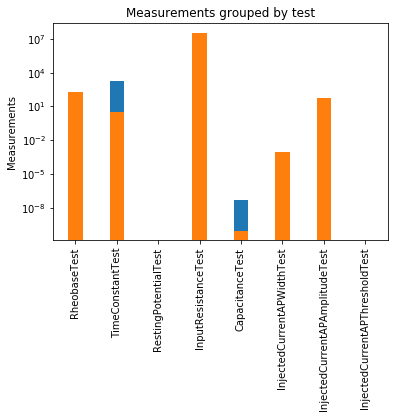

[array(179.296875) * pA,
 array(3.12335512) * ms,
 array(-67.18013407) * mV,
 array(33614307.5695503) * kg*m**2/(s**3*A**2),
 array(9.29174315e-11) * s**4*A**2/(kg*m**2),
 array(0.0009) * s,
 array(56.67603573) * mV,
 array(-17.771102) * mV]

In [24]:


width = 0.35       
mean_o_dict = { k:mean_o_dict[k] for k in preds.keys() }
measure0 = list(mean_o_dict.values())
N = len(measure0)
ind = np.arange(N)    # the x locations for the groups

measure1 = list(preds.values())
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit([measure0,measure1])
measure = scaler.transform([measure0,measure1])
#measure0 = scaler.transform([measure0,measure1])

plt.bar(ind,measure0, width)
plt.bar(ind,measure1, width)
plt.semilogy()


plt.ylabel('Measurements')
plt.title('Measurements grouped by test')
plt.xticks(ind, (list(preds.keys())))
plt.xticks(rotation=90)
plt.show()
measure1

In [ ]:
mean_o_dict;



width = 0.35       # the width of the bars: can also be len(x) sequence

measure0 = list(mean_o_dict.values())
N = len(measure0)
ind = np.arange(N)    # the x locations for the groups

measure1 = list(preds.values())


plt.bar(1,mean_o_dict['InputResistanceTest'], 1)
plt.bar(1,preds['InputResistanceTest'], 1)
#plt.semilogy()


plt.ylabel('InputResistanceTest')
plt.title('InputResistanceTest grouped by test')

preds.pop("InputResistanceTest",None)
mean_o_dict.pop("InputResistanceTest",None)

#plt.xticks(ind, (list(preds.keys())))
#plt.xticks(rotation=90)
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


width = 0.35       # the width of the bars: can also be len(x) sequence

measure0 = list(mean_o_dict.values())
N = len(measure0)
ind = np.arange(N)    # the x locations for the groups

measure1 = list(preds.values())


plt.bar(1,mean_o_dict['TimeConstantTest'], 1)
plt.bar(1,preds['TimeConstantTest'], 1)
#plt.semilogy()


plt.ylabel('TimeConstantTest')
plt.title('TimeConstantTest grouped by test')

preds.pop("TimeConstantTest",None)
mean_o_dict.pop("TimeConstantTest",None)

#plt.xticks(ind, (list(preds.keys())))
#plt.xticks(rotation=90)
plt.show()


tStat, pValue =  scipy.stats.ttest_1samp(a, popmean, axis=0)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat)) #print the P-Value and the T-Statistic

In [ ]:
mean_o_dict;

import numpy as np
import matplotlib.pyplot as plt


width = 0.35       # the width of the bars: can also be len(x) sequence

measure0 = list(mean_o_dict.values())
N = len(measure0)
ind = np.arange(N)    # the x locations for the groups

measure1 = list(preds.values())


plt.bar(1,mean_o_dict['InjectedCurrentAPAmplitudeTest'], 1)
plt.bar(1,preds['InjectedCurrentAPAmplitudeTest'], 1)
#plt.semilogy()


plt.ylabel('InjectedCurrentAPAmplitudeTest')
plt.title('InjectedCurrentAPAmplitudeTest grouped by test')

preds.pop("InjectedCurrentAPAmplitudeTest",None)
mean_o_dict.pop("InjectedCurrentAPAmplitudeTest",None)

#plt.xticks(ind, (list(preds.keys())))
#plt.xticks(rotation=90)
plt.show()
measure1

In [ ]:
#plt.bar(range(0,len(measure1)),measure1, width)
#plt.semilogy()
plt.plot(range(0,len(measure1)),measure1)
plt.plot(range(0,len(measure0)),measure0)


plt.ylabel('Measurements')
plt.title('Measurements grouped by test')
plt.xticks(ind, (list(preds.keys())))
plt.xticks(rotation=90)
plt.show()
measure1

In [ ]:







def initialise_test(v,rheobase):
    v = switch_logic([v])
    v = v[0]
    k = v.name
    if not hasattr(v,'params'):
        v.params = {}
    if not 'injected_square_current' in v.params.keys():    
        v.params['injected_square_current'] = {}
    if v.passive == False and v.active == True:
        keyed = v.params['injected_square_current']
        v.params = active_values(keyed,rheobase)
        v.params['injected_square_current']['delay'] = DELAY
        v.params['injected_square_current']['duration'] = DURATION
    if v.passive == True and v.active == False:

        v.params['injected_square_current']['amplitude'] =  -10*pq.pA
        v.params['injected_square_current']['delay'] = PASSIVE_DELAY
        v.params['injected_square_current']['duration'] = PASSIVE_DURATION

    if v.name in str('RestingPotentialTest'):
        v.params['injected_square_current']['delay'] = PASSIVE_DELAY
        v.params['injected_square_current']['duration'] = PASSIVE_DURATION
        v.params['injected_square_current']['amplitude'] = 0.0*pq.pA    
        
    return v

class NUFeature(object):
    def __init__(self,test,model):
        self.test = test
        self.model = model
    def calculate_score(self,responses):
        model = responses['model'].dtc_to_model()
        model.attrs = responses['params']
        
        ##
        # Last 4 lines entered
        ##
        if responses['rheobase'] is None:
            return 100.0
        if type(responses['rheobase']) is type(dict()):
            if responses['rheobase']['value'] is None:
                return 100.0
        self.test = initialise_test(self.test,responses['rheobase'])
        #if "RestingPotential" in str(self.test.name):            
        #    print(self.test.observation,self.test.prediction)
        if "Rheobase" in str(self.test.name):
            prediction = {'value':responses['rheobase']}

            score_gene = self.test.compute_score(self.test.observation,prediction)
            try:

                lns = np.abs(score_gene.log_norm_score)
            except:
                # works 1/2 time that log_norm_score does not work
                # more informative than nominal bad score 100
                #lns = float(score_gene.raw)

                lns = np.abs(float(score_gene.raw))
            return lns

        else:
            try:
                score_gene = self.test.judge(model)
            except:
                return 100.0

        if not isinstance(type(score_gene),type(None)):
            if not isinstance(score_gene,sciunit.scores.InsufficientDataScore):
                if not isinstance(type(score_gene.log_norm_score),type(None)):
                    try:

                        lns = np.abs(score_gene.log_norm_score)
                    except:
                        # works 1/2 time that log_norm_score does not work
                        # more informative than nominal bad score 100
                        s
                else:
                    # works 1/2 time that log_norm_score does not work
                    # more informative than nominal bad score 100

                    lns = np.abs(score_gene.raw)
            else:
                prediction = self.test.generate_prediction(model)
                lns = 100
        if lns==np.inf:
            

            lns = float(score_gene.raw)
        return lns

    
objectives = []
#for protocol in sweep_protocols:
#    stim_start = protocol.stimuli[0].step_delay
#    stim_end = stim_start + protocol.stimuli[0].step_duration
    
for tt in nu_tests:
    feature_name = '%s.%s' % (tt.name, tt.name)
    ft = NUFeature(tt,model)
    objective = ephys.objectives.SingletonObjective(
        feature_name,
        ft)
    objectives.append(objective)

score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 
        
        
#objectives[0]        



# ### Creating the cell evaluator
# 
# We will need an object that can use these objective definitions to calculate the scores from a protocol response. This is called a ScoreCalculator.




lop={}
from bluepyopt.parameters import Parameter
for k,v in MODEL_PARAMS["IZHI"].items():
    p = Parameter(name=k,bounds=v,frozen=False)
    lop[k] = p

print(lop)
simple_cell.params = lop

nu_tests[0].judge(simple_cell)

nu_tests[0].score_type = ZScore


# Combining everything together we have a CellEvaluator. The CellEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.05)]:

    protocol = ephys.protocols.SweepProtocol(protocol_name, [None], [None])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

MODEL_PARAMS["IZHI"]
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=MODEL_PARAMS["IZHI"].keys(),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim='euler')
simple_cell.params_by_names(MODEL_PARAMS["IZHI"].keys())
simple_cell.params;


# ### Evaluating the cell
# 
# The cell can now be evaluate for a certain set of parameter values.

# In[ ]:


#default_params = MODEL_PARAMS["IZHI"]
#print(cell_evaluator.evaluate_with_dicts())


# ## Setting up and running an optimisation
# 
# Now that we have a cell template and an evaluator for this cell, we can set up an optimisation.
import dask
def dask_map_function(eval_,invalid_ind):
    results = []
    for x in invalid_ind:
        y = dask.delayed(eval_)(x)
        results.append(y)
    fitnesses = dask.compute(*results)
    return fitnesses



MU =100
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = MU,
        map_function = dask_map_function,
        selector_name='IBEA',
        mutpb=0.05,
        cxpb=0.4)


# And this optimisation can be run for a certain number of generations



final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=100)



In [ ]:


# The optimisation has return us 4 objects: final population, hall of fame, statistical logs and history. 
# 
# The final population contains a list of tuples, with each tuple representing the two parameters of the model


print('Final population: ', final_pop)


# The best individual found during the optimisation is the first individual of the hall of fame

best_ind = hall_of_fame[0]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}



opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}

check_binary_match(target,opt)
inject_and_plot_passive_model(opt,second=target)


# As you can see the evaluation returns the same values as the fitness values provided by the optimisation output. 
# We can have a look at the responses now.

# In[ ]:


#plot_responses(twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn))
 


# Let's have a look at the optimisation statistics.
# We can plot the minimal score (sum of all objective scores) found in every optimisation. 
# The optimisation algorithm uses negative fitness scores, so we actually have to look at the maximum values log.

gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 

In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.yscale('log')

plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(1,1)

plt.plot(gen_numbers, min_fitness, label='min fitness')
#ax.semilogy()
#ax.set_yscale('log')
plt.yscale('log')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
inject_and_plot_passive_model(opt,second=target,plotly=False)

In [ ]:
check_binary_match(opt,target,plotly=False,snippets=False)
check_binary_match(opt,target,plotly=False,snippets=True)

In [ ]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

In [ ]:
objectives

In [ ]:
opt = dtc_to_rheo(opt)
print(opt.rheobase)

In [ ]:
target.rheobase

In [ ]:
params = {}
params['injected_square_current'] = {}
#if v.name in str('RestingPotentialTest'):
params['injected_square_current']['delay'] = PASSIVE_DELAY
params['injected_square_current']['duration'] = PASSIVE_DURATION
params['injected_square_current']['amplitude'] = 0.0*pq.pA    

In [ ]:

opt_model = opt.dtc_to_model()
opt_model.inject_square_current(params)
opt_vm = opt_model.get_membrane_potential()
opt_vm[-1]

In [ ]:
target_model = target.dtc_to_model()
target_model.inject_square_current(params)
target_vm = target_model.get_membrane_potential()
target_vm[-1]

In [ ]:
best_ind = hall_of_fame[1]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
dtc= model.model_to_dtc()
opt = dtc_to_rheo(opt)
print(opt.rheobase)

In [ ]:
#model.rheobase

In [ ]:
len(hist.genealogy_history)/20

In [ ]:
import pandas as pd
import seaborn as sns
logbook = logs
#scores = [ m for m in logs ]
'''
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

'''
MU =20
genes=[]
min_per_generations = []
for i,v in hist.genealogy_history.items():
    if i%25==0:
        min_per_gen = sorted([(gene,np.min(gene)) for gene in genes],key=lambda x: x[1])
        min_per_generations.append(min_per_gen[0][0])
        genes =[]
    genes.append(v.fitness.values)
df2 = pd.DataFrame()
scores = []
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    if j<len(min_per_generations):
        df2[index] = pd.Series(min_per_generations).values[j]#, index=df1.index)
        #scores.append(df2[str(i)])
df2    

#rescored = [np.sum(i) for i in range(0,len(scores)) ]
#rescored

In [ ]:
import math
import seaborn as sns
sns.set(style="darkgrid")

fig,axes = plt.subplots(3,3,figsize=(20,20))#math.ceil(len(objectives)/2+1),figsize=(20,20))
axes[0,0].plot(gen_numbers, min_fitness, label='min fitness')

axes[0,0].set_title('Observation/Prediction Disagreement')
for i,c in enumerate(df2.columns):
    ax = axes.flat[i+1]
    history = df2[c]
    #mn = mean[k.name] 
    #st = std[k.name] 
    #history = [(j[i]-mn)/st for j in scores ]
    #ax.axhline(y=mn , xmin=0.02, xmax=0.99,color='red',label='best candidate sampled')

    #ax.axvline(x=min_x , ymin=0.02, ymax=0.99,color='blue',label='best candidate sampled')
    ax.plot(history)
    ax.set_title(str(c))
    #bigger = np.max([np.max(history),mn])
    #smaller = np.max([np.min(history),mn])

    #ax.set_ylim([np.min(history),np.max(history)])
    #ax.set_ylabel(str(front[0].dtc.tests[i].observation['std'].units))
axes[0,0].set_xlabel("Generation")
axes[0,0].set_ylabel("standardized error")

plt.tight_layout()
#if figname is not None:
#    plt.savefig(figname)
#else:
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
logbook = logs
#scores = [ m for m in logs ]
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()


In [ ]:
print(np.sum(np.sum(corr)))